# Quickstart Guide

This guide will give a quick intro to training PyTorch models with HugsVision. We'll start by loading in some data and defining a model, then we'll train it for a few epochs and see how well it does.

**Note**: The easiest way to use this tutorial is as a colab notebook, which allows you to dive in with no setup. We recommend you enable a free GPU with

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

**Note**: You need to have at least Python 3.6 to run the scripts.

## Install HugsVision

First we install HugsVision if needed. 

In [ ]:
try:
    import hugsvision
except:
    !pip install -q hugsvision
    import hugsvision
    
print(hugsvision.__version__)

## Downloading Data

First, we need to download the dataset called `Kvasir Dataset v2` [here](https://datasets.simula.no/kvasir/) which weight around ~2.3 GB.

## Loading Data

Once it has been converted, we can start loading the data.

In [ ]:
from hugsvision.dataio.VisionDataset import VisionDataset

train, test, id2label, label2id = VisionDataset.fromImageFolder(
	"./data/",
	test_ratio   = 0.15,
	balanced     = True,
	augmentation = True,
)

## Choose a image classifier model on HuggingFace

Now we can choose our base model on which we will perform a fine-tuning to make it fit our needs.

Our choices aren't very large since we haven't a lot of model available yet on HuggingFace for this task.

So, to be sure that the model will be compatible with `HugsVision` we need to have a model exported in `PyTorch` and compatible with the `image-classification` task obviously.

Models available with this criterias: [here](https://huggingface.co/models?filter=pytorch&pipeline_tag=image-classification&sort=downloads)

At the time I'am writing this, I recommand to use the following models:

* `google/vit-base-patch16-224-in21k`
* `google/vit-base-patch16-224`
* `facebook/deit-base-distilled-patch16-224`
* `microsoft/beit-base-patch16-224`

**Note:** Please specify `ignore_mismatched_sizes=True` for both `model` and `feature_extractor` if you aren't using the following model.


In [ ]:
huggingface_model = 'google/vit-base-patch16-224-in21k'

## Train the model

So, once the model choosen, we can start building the `Trainer` and start the fine-tuning.

**Note**: Import the `FeatureExtractor` and `ForImageClassification` according to your previous choice.


In [ ]:

from hugsvision.nnet.VisionClassifierTrainer import VisionClassifierTrainer
from transformers import ViTFeatureExtractor, ViTForImageClassification

trainer = VisionClassifierTrainer(
	model_name   = "MyKvasirV2Model",
	train      	 = train,
	test      	 = test,
	output_dir   = "./out/",
	max_epochs   = 20,
	batch_size   = 32, # On RTX 2080 Ti
    lr 		     = 2e-5,
	fp16	     = True,
	model = ViTForImageClassification.from_pretrained(
	    huggingface_model,
	    num_labels = len(label2id),
	    label2id   = label2id,
	    id2label   = id2label
	),
	feature_extractor = ViTFeatureExtractor.from_pretrained(
		huggingface_model,
	),
)

## Evaluate F1-Score

Using the F1-Score metrics will allow us to get a better representation of predictions for all the labels and find out if their are any anomalies wit ha specific label.

In [ ]:
ref, hyp = trainer.evaluate_f1_score()

```
                        precision    recall  f1-score   support

    dyed-lifted-polyps       0.97      0.97      0.97       135
dyed-resection-margins       0.97      0.97      0.97       149
           esophagitis       0.93      0.83      0.87       173
          normal-cecum       0.95      0.99      0.97       152
        normal-pylorus       0.99      1.00      1.00       151
         normal-z-line       0.82      0.93      0.87       149
                polyps       0.96      0.94      0.95       141
    ulcerative-colitis       0.98      0.95      0.97       150

              accuracy                           0.94      1200
             macro avg       0.95      0.95      0.95      1200
          weighted avg       0.95      0.94      0.94      1200
```

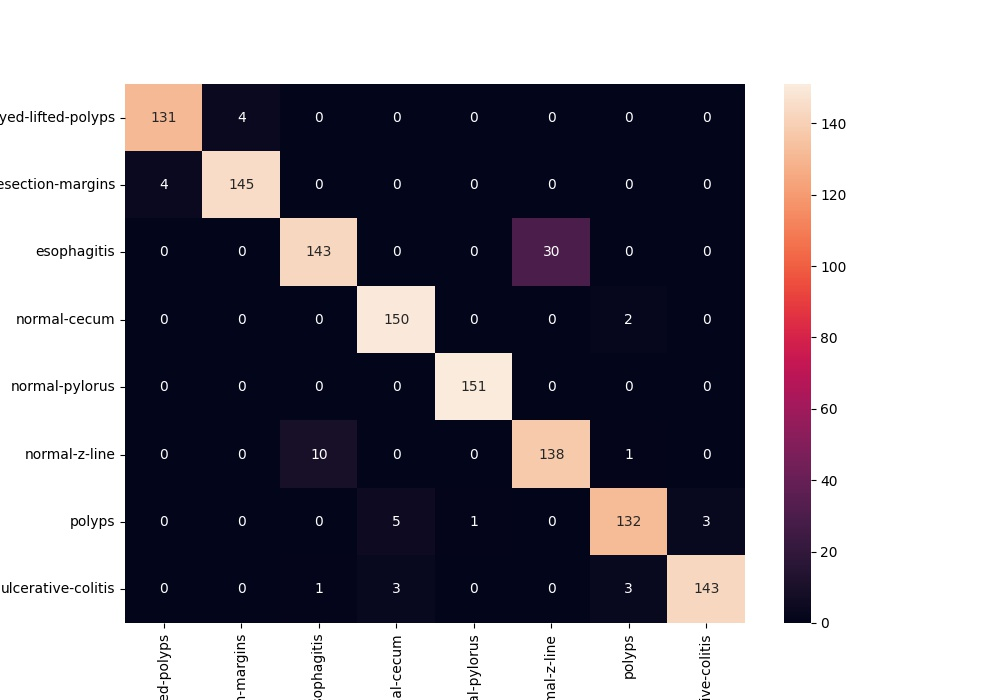

## Make a prediction

Rename the `./out/MODEL_PATH/config.json` file present in the model output to `./out/MODEL_PATH/preprocessor_config.json`


In [ ]:
import os.path
from transformers import ViTFeatureExtractor, ViTForImageClassification
from hugsvision.inference.VisionClassifierInference import VisionClassifierInference

path = "./out/MyKvasirV2Model/20_2021-08-20-01-46-44/model/"
img  = "../../../samples/kvasir_v2/dyed-lifted-polyps.jpg"

classifier = VisionClassifierInference(
    feature_extractor = ViTFeatureExtractor.from_pretrained(path),
    model = ViTForImageClassification.from_pretrained(path),
)

label = classifier.predict(img_path=img)
print("Predicted class:", label)